## Executive Summary:
- Strong correlation between some feature usages and user conversion is observed
- Adding a new user and receiving the first bill seem to be the most affecting features
- model is trained and fine tuned for conversion prediciton
- Based on the current work, user conversion can be predicted with 0.92 accuracy (0.95 precision and 0.80 recall)
- inference on the test data set is stored in 'test_predictions.csv'
- total of 5 hours are spent on this work over 2 days

## Objectves
- Understanding the data
- Crating hypothesis regarding the relations between user activities and conversion
- Creating a model to predict conversion

## Assumptions
- time to first bill: the definition was ambigous, based on the correlation with other metrics, I assumed it means time for the customer to receive the first bill from Clio. It is not very critical in prediction, but such assumption affects the justifications. It would be something I would clarify first if time contraints allowed.



# EDA
Let's take a look at the data format and general values of the data. Null values are very abundant in this dataset and extra care is required for their handling because they are not simply missing values but they actually present a certain user behavior. Therefore imputation is not an option here. Any model to be used should be capable of handling NaN as input. 


NaNs in the the dependent variables (time_to_conversion, conversion_value) can actually be handled more traditonally (e.g. conversion_value of NaN can be replaced by 0), but since the main goal is to optimize the conversion rate and not any of these two variables, I won't work too much on them.

In [5]:
#!pip install xgboost

In [178]:
# Load libraries
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier, plot_importance
from sklearn.impute import SimpleImputer
from scipy import stats
import seaborn as sns
import warnings
import xgboost

warnings.filterwarnings(action='once')
sns.set(style="white")

In [97]:
train_df = pd.read_csv('train.csv')

In [98]:
train_df['isConverted'] = train_df['conversion_value']>0
train_df['isConverted'] =train_df['isConverted'].astype(int)
train_df.head()

,idx,time_to_first_matter,time_to_first_time_entry,time_to_first_bill,time_to_second_user,page_views_in_first_hour,page_views_in_first_day,page_views_in_first_7_days,page_views_in_first_14_days,time_to_conversion,conversion_value,isConverted
0,745,NaN,NaN,NaN,NaN,12.0,12.0,12.0,12.0,NaN,NaN,0
1,1190,117.0,117.0,223.0,280881.0,16.0,16.0,31.0,31.0,281245.0,140.0,1
2,1242,351.0,448.0,NaN,NaN,20.0,20.0,20.0,20.0,NaN,NaN,0
3,1044,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,NaN,NaN,0
4,304,NaN,NaN,NaN,NaN,4.0,4.0,4.0,4.0,NaN,NaN,0


proportion of non-converted and converted clinets:


0    0.829
1    0.171
Name: isConverted, dtype: float64

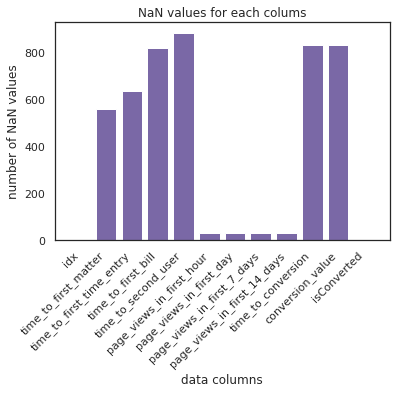

In [99]:
plt.bar(train_df.columns, train_df.isnull().sum(axis = 0), align='center', color='#7A68A6')
plt.xticks(rotation=45, ha="right");
plt.xlabel('data columns');
plt.ylabel('number of NaN values');
plt.title('NaN values for each colums' );

print('proportion of non-converted and converted clinets:')
train_df['isConverted'].value_counts() / len(train_df['isConverted'])

# Data Cleaning
Another interesting case, is of those user who converted to paid subscription without trying the key software features. Such behavior can be called an anomaly (even if it is not, it cannot give us any insight regarding the conversion reason), therefore I decided to ignore any value for such such behavior (replace those with NaN). Anotehr option is to remove rows with such behavior, but that affect almost half of converted population and makes the dataset way more unbalanced.

Another potential issue is the page_view counts for time intervals after conversion, I didn't touch them in this work but one approach would be to replace any value for $t>t_{conversion}$ with its projection from the previous values (e.g. if converison happened at day 10, regress the 14 days view count from 1hr, 1day, 7 days view counts and use that instead of the measured value)

In [100]:
#Cleaning the data by replacing time-to-actions after conversion with NaNs

cols_to_compare = ['time_to_first_matter','time_to_first_time_entry','time_to_first_bill','time_to_second_user']
modified_vals_cnt=0
for col in cols_to_compare:
#     print(train_df.loc[train_df[col]>train_df['time_to_conversion'],[col]])
    idx_bool=train_df[col]>train_df['time_to_conversion']
    idx=[i for i in idx_bool.index if idx_bool[i]]
    # replace the irrelevant value with NaN
    train_df.loc[idx_bool,[col]]=np.nan
    
    #Another option is to remove the whole row
    #train_df.drop(index=idx,axis=0, inplace=True)
    modified_vals_cnt += len(idx)

print('total modified values: {}'.format(modified_vals_cnt))


total modified values: 147


# Insight about data


The first Figure below, shows that all features are very positively skewed, and a data transformation is usually suggested (e.g. BoxCox). I applied a log transform and performed the prediction and no extra gain was achieved, therefore, I don't include that work in this report.

Next I look at the distribution of the values for converted vs unconverted accounts. Significant difference is observed for many features suggesting correlation of those metrics with account conversion. This is also verified by looking at the correlation between features and their distributions in the heat map.

There are features with strong correlation with convertion rate:
- __All the page_view metrics__: This should be expected, the more interested the users are in the software, more interactions they would have. This correlation is least likely to be causal (i.e. increasing the page_view with any means is unlikely to increase the conversion rate. There should a confounding factor affecting both values). Think about an experiment where we artificially force users to have more page_view, let's say by adding extra unnecessary steps to certain procedures, I wouldn't think it would help conversion. Furthermore, we should note that all page_view metrics are highly correlated and should not all be counted as independent variables. 

- __time to add a second user__: this is pomissing, the lower mean value for converted accounts (from the box plot), and significantly large negative corrlation (-0.22) suggests strong ties between this variable and conversion rate. This is expected from both correlation and causal aspects. The correlation comes from the fact that *the more usefull you find the software, the more likely to add a user and utilize its team features*, and the causal point of view could be *once you added a second user and become familiar with the multi-user features, it would be more likely to appreciate the software and pay for it*.
    - We can generate a **statistical hypotesis**; *Converted account have smaller time_to_second_user values* and test that with a t-test.
    - I think here we are looking for **Business and Cauasl Hypotesis**, especially, *reducing the time_to_second_user would increase the conversion rate*. Unfortunately, no cauasal inference can be made with this observational study, this is a good candidate for A/B testing.
- __time_to_first_bill__: another pomissing observation, the higher mean value for converted accounts (from the box plot), and significantly large positive corrlation (-0.24) suggests strong ties between this variable and conversion rate. Here my justification would be: *if client receive the bill too early, before complete evaluation, they would back off and leave the software without complete exploration.*
    - **Business and Causal Hypotesis**: *increasing the time_to_first_bill would increase the conversion rate*. another good candidate for A/B testing.

There are also other feature that we could hypothesise to affect the conversion:
- trends in page_views : looking at how the page views scale over time, could help the prediction and could be a good leading indicator for conversion. Users with higher page_view scale ups, are expected to have higher conversion rates. 
- difference between first meaningfull interactions and first bill. I would imagin the time between user activities and receving the bill would affect the conversion rate even more directly than time_to_first_bill. 

later in the code, I added these features to enhance the prediction accuracy. I wrote a custom transformer to take care of standardization and adding the new features.

# Possible A/B tests:
## reducing the time_to_second_user would increase the conversion rate
New accounts should be randomized into equally sized Control and Treatment Groups. Control receive the default experince. Treatment would be encouraged to add a second user, e.g. by a walkthgough tutorial, highlighting all the steps for such actions. At the end of the experiment (1 month) all client's data would be logged and the conversion rate would be compared using a t-test. A sanity check would be to compare the time_to_second_user metric, it should be lower in the treatment. With not so large number of new clients, a power analysis should be performed before each experiment to make sure the expected treatment effect is detectable with current number of clients. If the test is underpowered, we can extend the expeiment length and/or use variance reduction techniques.

## increasing the time_to_first_bill would increase the conversion rate
With this one, we want to make sure the first bill does not show early in the onboarding process. for the treatment, we can force the bill to only show up once the trial period is about to end, this give more time to new clients to explore before they make decisions on conversion.



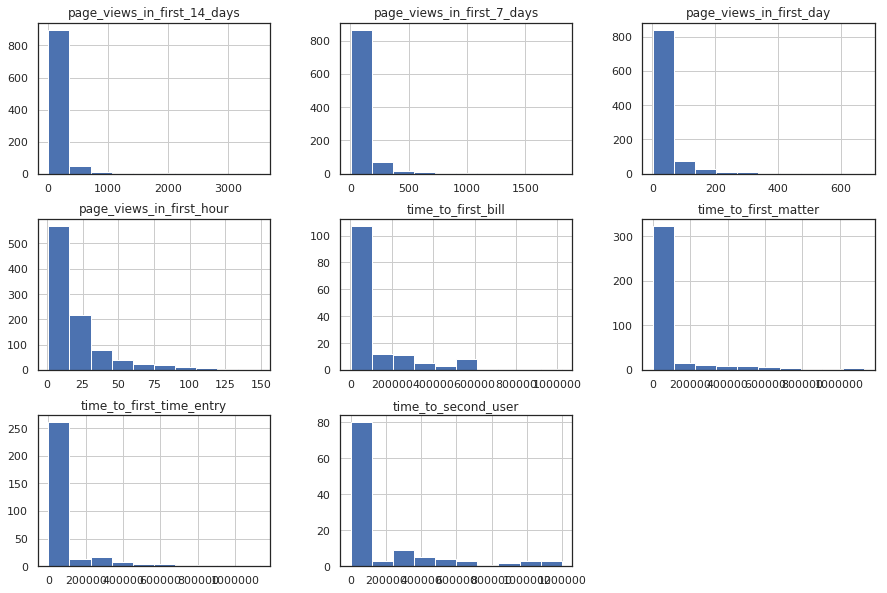

In [30]:
train_df[train_cols].hist(figsize =(15,10))
plt.show()

In [77]:
train_cols=['time_to_first_matter','time_to_first_time_entry','time_to_first_bill','time_to_second_user','page_views_in_first_hour','page_views_in_first_day','page_views_in_first_7_days','page_views_in_first_14_days']
train_df_log = pd.DataFrame()
for col in train_cols:
    train_df_log[col]=train_df[col].apply(lambda x: np.log(x))
train_df_log['isConverted'] =  train_df['isConverted']

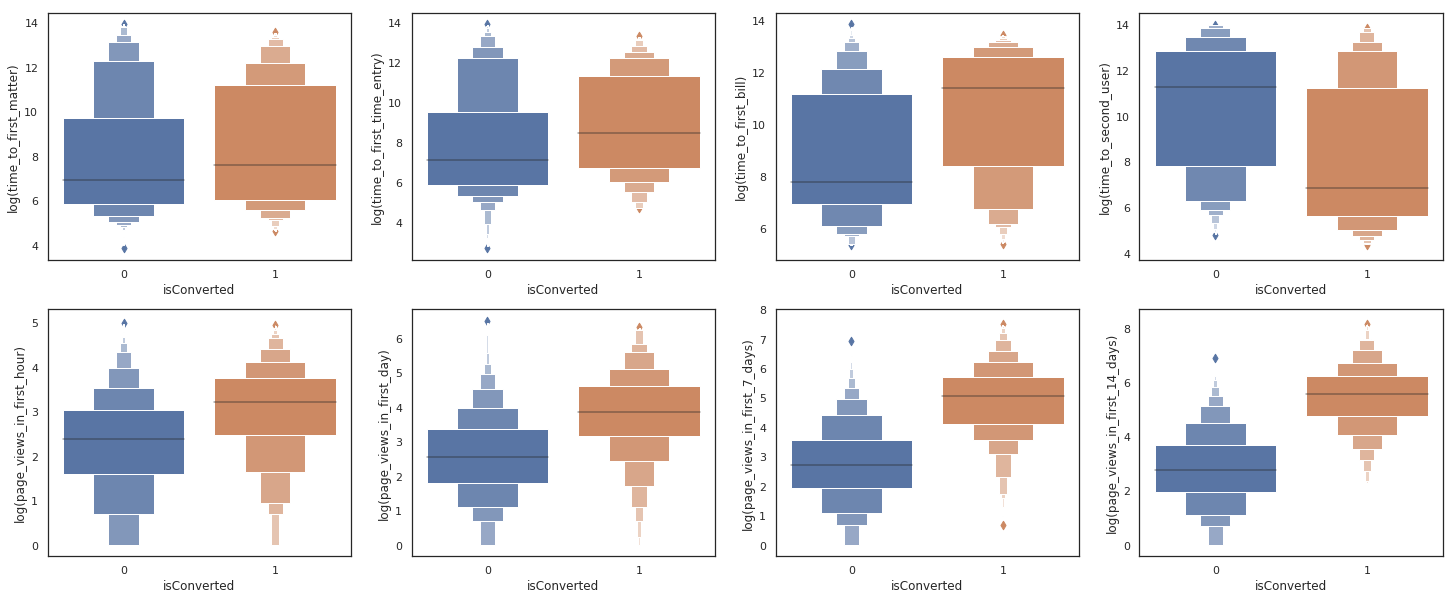

In [90]:
plt.figure(figsize=(25,10))
for i,col in enumerate(train_cols):
    plt.subplot(2,4,i+1)
    sns.boxenplot(x='isConverted', y = col, data = train_df_log)
    plt.ylabel('log({})'.format(col))

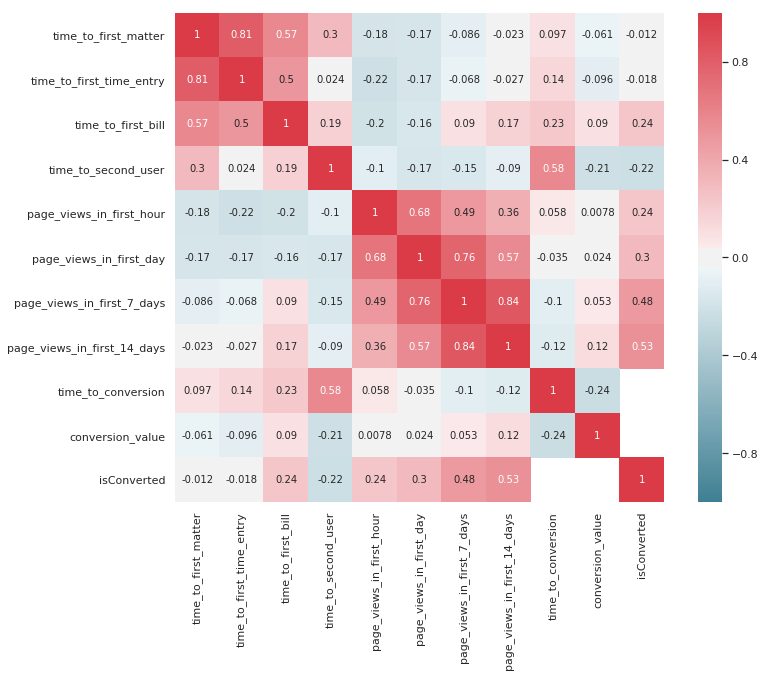

In [29]:
corrmat = train_df[['time_to_first_matter', 'time_to_first_time_entry',
       'time_to_first_bill', 'time_to_second_user', 'page_views_in_first_hour',
       'page_views_in_first_day', 'page_views_in_first_7_days',
       'page_views_in_first_14_days', 'time_to_conversion', 'conversion_value',
       'isConverted']].corr()
fig, ax = plt.subplots(figsize=(12, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrmat, cmap=cmap, vmin=-1, vmax=1, cbar=True, annot=True, square=True);
plt.show()

## Model Training
Here is a summary of what I've done bellow:
- added a transformation class so that we can easily apply the same transformation to test data later. This class adds the new features and standardizes them.
- Because of the highly unbalanced data, I use stratification for train-validation split and also use f-1 score instead of accuracy
- 10 fold cross validation is used to evalute the basif performance to avoid overfitting and have more reliable comparison not affected by certain randomizaiton.
- Trained a gradient boosted decision trees (XGBoost). It automatticaly handles NaNs (thinking of them as a new category) and is known to be very effective. Without any model tuning:
    - 5 fold cross validated f1:**0.738**
- other models are also tested with some data modification, but XGBoost had the best performance. 
- fine tuning XGBoost parameters improved the performance to:
    - 5 fold cross validated f1:**0.775**
    
- Model interpretation: Given the non-linear nature of the problem and requirent for ternary spliting ( >x, <x, NaN), XGBoost looked like a good option and it showed better perfornace than other tested models. Tree-based model can easily overfit training data, therefore, cross-vaidation is a must for model tuning.
    
- feature importance chart suggests that most of the prediciton comes from "Page_views". We cannot read a lot from it since we havn't removed highly correlated features.
- test data is loaded and transformed. Prediction results are added to the data.


In [229]:
class featureModifier(BaseEstimator, TransformerMixin):
    """
    A class to add the new features and standardize all features.
    """
    def __init__(self):
        self.feature_cols=[]
        self.scaler = StandardScaler()
        pass    
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None, train = True):
        df = X.copy()
        
        # Calculate the scaling of page_view counts with time. 
        df['page_view_day_scale']=df['page_views_in_first_day']/df['page_views_in_first_hour']
        df['page_view_week_scale']=df['page_views_in_first_7_days']/df['page_views_in_first_day']
        df['page_view_2_weeks_scale']=df['page_views_in_first_14_days']/df['page_views_in_first_7_days']
        
        # Calculate difference in times to actions. 
        df['time_from_first_entry_to_first_bill']=df['time_to_first_bill']-df['time_to_first_time_entry']
        df['time_from_second_user_to_first_bill']=df['time_to_first_bill']-df['time_to_second_user']
        df['time_from_first_matter_to_first_bill']=df['time_to_first_bill']-df['time_to_first_matter']

                       
        # With that we can remove columns from the dataset
        cols2drop = []
        df.drop(cols2drop, axis=1, inplace=True)
        self.feature_cols = list(df.columns)
        if train:
            self.scaler.fit(df)
            
        df = pd.DataFrame(self.scaler.transform(df))
        df.columns=self.feature_cols
        
        return df

In [230]:
train_cols=['time_to_first_matter','time_to_first_time_entry','time_to_first_bill','time_to_second_user','page_views_in_first_hour','page_views_in_first_day','page_views_in_first_7_days','page_views_in_first_14_days']
# Transform and Split-out validation dataset
customTransformer = featureModifier().fit(train_df[train_cols])
X = customTransformer.transform(train_df[train_cols], train = True)
y = train_df['isConverted']
extended_train_cols= customTransformer.feature_cols
validation_size = 0.20
seed = 37
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed, stratify=y)

In [233]:
seed = 7
xgb0=XGBClassifier()
kfold = model_selection.KFold(n_splits=5, random_state=seed)
cv_results = model_selection.cross_val_score(xgb0, X_train, y_train, cv=kfold, scoring='f1')
msg = "%s: %f (%f)" % ('XGB Performance, f1', cv_results.mean(), cv_results.std())
print(msg)
kfold = model_selection.KFold(n_splits=5, random_state=seed)
cv_results = model_selection.cross_val_score(xgb0, X_train, y_train, cv=kfold, scoring='accuracy')
msg = "%s: %f (%f)" % ('XGB Performance, accuracy', cv_results.mean(), cv_results.std())
print(msg)

XGB Performance, f1: 0.738429 (0.075036)
XGB Performance, accuracy: 0.912500 (0.030362)


## Extending to other models

XGB classifer is performing reasonably well, but unfortunately, there are not many implementations of other classifiers that can handle NaNs. One way to overcome this, is to replace NaNs with a very out of range value, and decive the classifier to handle it specificly. This works specifically well for tree like classifers and will allow up to test more models.
**XGB** and **RandomForest** stayed the most promissing models. I'll use those for fine-tuning and optimizing the performance.


In [47]:
# replace NaNs with -999
imp_constant = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value = -999)
X_train_noNaN = imp_constant.fit_transform(X_train)

In [48]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(('xgb',XGBClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RFC',RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train_noNaN, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.637407 (0.139750)
LDA: 0.537561 (0.106239)
KNN: 0.580511 (0.075462)
TREE: 0.682332 (0.084320)
xgb: 0.738926 (0.123851)
SVM: 0.560529 (0.078248)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/l

RFC: 0.722225 (0.135511)


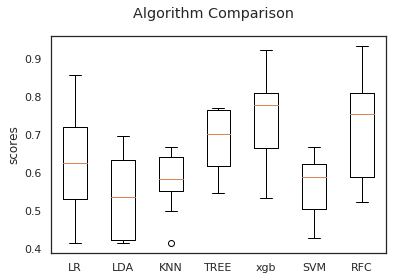

In [234]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('scores')
plt.show()

In [238]:
# Make predictions on validation dataset
xgb0 = XGBClassifier()
xgb0.fit(X_train, y_train)
predictions = xgb0.predict(X_validation)
print('accuracy',accuracy_score(y_validation, predictions))
print('f1-score',f1_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

accuracy 0.915
f1-score 0.7384615384615385
[[159   7]
 [ 10  24]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       166
           1       0.77      0.71      0.74        34

   micro avg       0.92      0.92      0.92       200
   macro avg       0.86      0.83      0.84       200
weighted avg       0.91      0.92      0.91       200



## Model Tuning
Here we use cross-validated grid search to fine-tune XGBoos model parameters.

In [241]:
param_test1 = {
 'max_depth':range(1,5,1),
 'min_child_weight':range(1,5,1)
}
gsearch1 = model_selection.GridSearchCV(estimator = XGBClassifier(), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 2, 'min_child_weight': 3}, 0.7566366808758878)

In [242]:
param_test2 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = model_selection.GridSearchCV(estimator = XGBClassifier( max_depth=2,
 min_child_weight=3), 
 param_grid = param_test2, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.0}, 0.7566366808758878)

In [243]:
param_test3 = {
    'subsample':[i/100.0 for i in range(20,90, 10)],
     'colsample_bytree':[i/100.0 for i in range(20,90, 10)]
}
gsearch3 = model_selection.GridSearchCV(estimator = XGBClassifier( max_depth=2,
 min_child_weight=3, gamma=0), 
 param_grid = param_test3, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.3}, 0.7690017516640808)

In [244]:
param_test4 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch4 = model_selection.GridSearchCV(estimator = XGBClassifier( max_depth=2,
 min_child_weight=3, gamma=0, subsample=0.3, colsample_bytree=0.7), 
 param_grid = param_test4, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

({'reg_alpha': 1e-05}, 0.7690017516640808)

In [245]:
xgb_tuned = XGBClassifier(
 max_depth=2,
 min_child_weight=3,
 gamma=0,
 subsample=0.3,
 colsample_bytree=0.7,
 reg_alpha = 1e-5,
 )
kfold = model_selection.KFold(n_splits=5, random_state=seed)
cv_results = model_selection.cross_val_score(xgb_tuned, X_train, y_train, cv=kfold, scoring='f1')
msg = "%s: %f (%f)" % ('XGB Performance, f1', cv_results.mean(), cv_results.std())
print(msg)


XGB Performance, f1: 0.774809 (0.085760)


In [246]:
# Make predictions on validation dataset
xgb_tuned.fit(X_train, y_train)
predictions = xgb_tuned.predict(X_validation)
print('accuracy',accuracy_score(y_validation, predictions))
print('f1-score',f1_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

accuracy 0.905
f1-score 0.7076923076923077
[[158   8]
 [ 11  23]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       166
           1       0.74      0.68      0.71        34

   micro avg       0.91      0.91      0.91       200
   macro avg       0.84      0.81      0.83       200
weighted avg       0.90      0.91      0.90       200



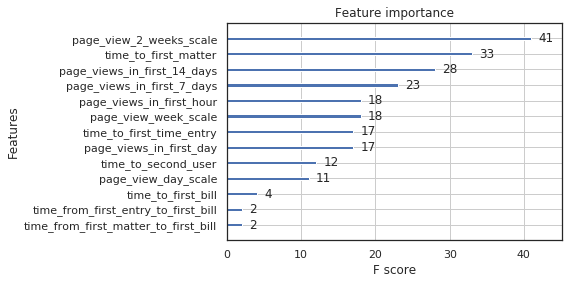

In [247]:
plot_importance(xgb_tuned)
plt.show()

# Inference on Test dataset
Here I perform the folloing tasks:
- load test dataset
- tranform test data
- make inference 
- store inference results into file

In [248]:
test_df = pd.read_csv('test.csv')
X_test = customTransformer.transform(test_df[train_cols], train = False)
#train the model all train data (not cross-validate)
xgb_tuned.fit(X, y)
predictions = xgb_tuned.predict(X_test)
test_df['isConverted'] = predictions
test_df.to_csv('test_predictions.csv')

In [249]:
conversion_vals = test_df['isConverted'].value_counts()/ len(test_df['isConverted'])
print('proportion of expected non-converted / expected converted clinets: {} / {}'.format(conversion_vals[0], conversion_vals[1]))

proportion of expected non-converted / expected converted clinets: 0.81 / 0.19


## Future Work
There were other actions that I would have performed with extended time:
- Feature reduction: Although generally non-linear models can handle highly correlated features, such multicolinearity reduces the interoretability of the features a lot. Therefore a VIF based feature reduction would have been usefull for hypothesis generation.
- Another approach to handle these NaN values which I think would have been better suited to this problem but will not cover, is to change the features into categorical variable:
    - certain action happened in first hour
    - certain action happened in first day
    - certain action happened in first week
    - certain action happened in first 2 weeks
    - certain action did not happen in first 2 weeks, this covers the NaN values
 
 and use these categorical variables for inference.